## This program uses a artificial neural network called LSTM
### pridicting stock price of a corporation (Apple Ins) using the past 60 day stock price

In [1]:
import math
import pandas_datareader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
from pandas_datareader import data as pdr
plt.style.use('fivethirtyeight')


In [2]:
#get the stock quote
yf.pdr_override()
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2024-01-01')
#show data
df

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433827,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500645,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639426,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771561,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751301,394024400
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700


In [3]:
#get the no. of rows and columns
df.shape

(3018, 6)

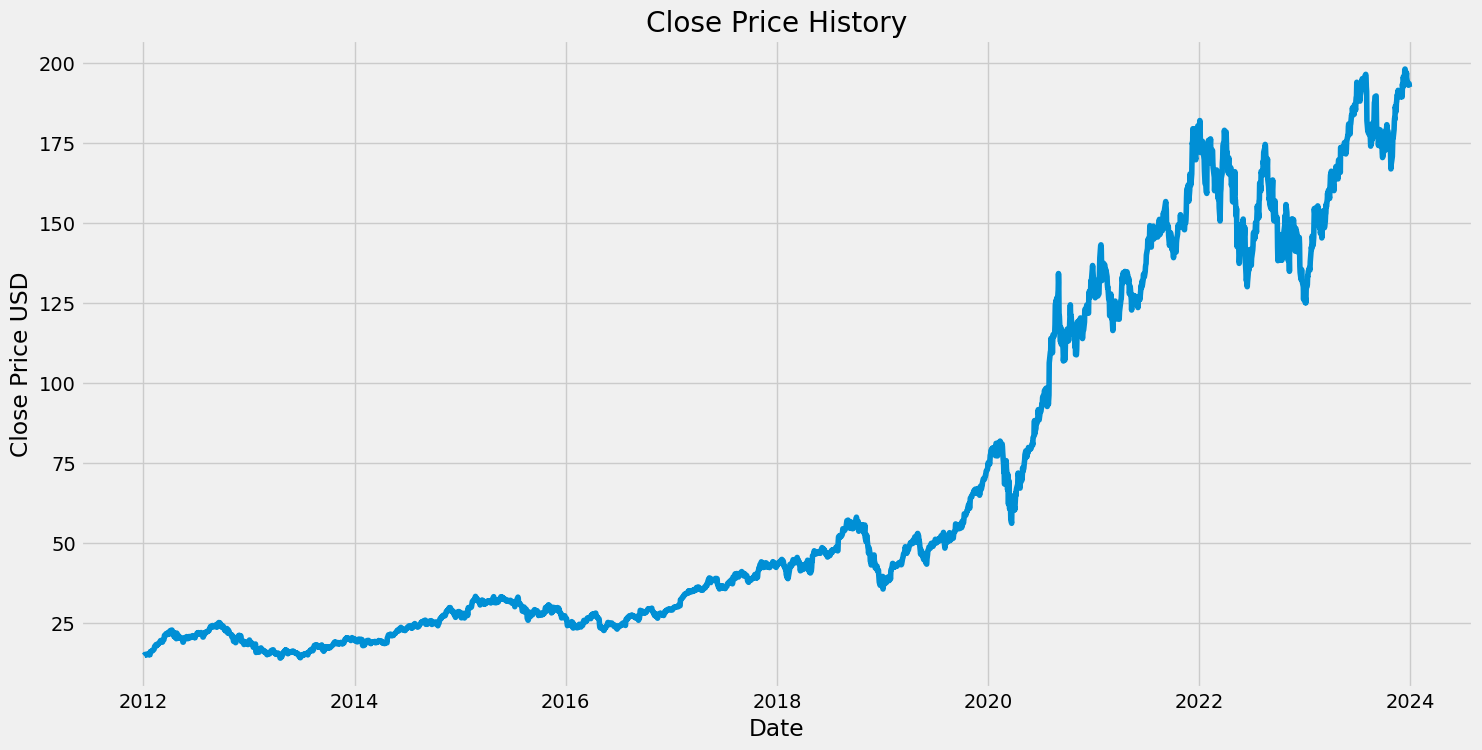

In [4]:
#visualise closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

In [13]:
#create new dataframe with only close column
data = df.filter(['Close'])
#convert dataframe to numpy array
dataset = data.values
print(data,dataset)
#get the number pf rows to train the LSTM model
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

                 Close
Date                  
2012-01-03   14.686786
2012-01-04   14.765714
2012-01-05   14.929643
2012-01-06   15.085714
2012-01-09   15.061786
...                ...
2023-12-22  193.600006
2023-12-26  193.050003
2023-12-27  193.149994
2023-12-28  193.580002
2023-12-29  192.529999

[3018 rows x 1 columns] [[ 14.6867857 ]
 [ 14.76571369]
 [ 14.92964268]
 ...
 [193.1499939 ]
 [193.58000183]
 [192.52999878]]


2415

In [12]:
#scale data
#scaling is always advantageous in preproccessing transformations to the input data before it is presented in neural network
#it convert the dataset into between 0 to 1 both inclusive
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.97306723],
       [0.97540217],
       [0.96970066]])

In [17]:
#create training dataset
#create scaled training dataset
train_data = scaled_data[0:training_data_len, :]
print(train_data)
#split data into xtrain and ytrain
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=60:
    print(x_train)
    print(y_train)

[[0.00401431]
 [0.00444289]
 [0.00533302]
 ...
 [0.72220184]
 [0.72279914]
 [0.71780356]]
[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]


In [18]:
#convert x_train, y_train to numpy arrays so we can use them for training LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)


In [19]:
#reshape xtrain dataset
#LSTM model requires 3D input
#number of samples = number of rows
#number of time steps = number of columns
#number of features = 1 i.e closing price
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2355, 60, 1)

In [20]:
#building LSTM model
model = Sequential()
#LSTM layer
#we are giving 50 neurons; return_sequence is True bcoz we are going to add another layer; as it is first layer so we give input_shape = number of time steps, features
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
#we are giving 50 neurons and return_sequence is False bcoz we are going to add another layer
model.add(LSTM(50, return_sequences = False))
#dense layer has 50 neurons
model.add(Dense(25))
#dense layer has 1 neuron
model.add(Dense(1))

In [22]:
#compile the model
#an optimizer is used to improve upon loss function
#loss function is used to measure how well the model did on training
model.compile(optimizer='adam', loss = 'mean_squared_error')


In [23]:
#training model
#The batch size is a number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset
model.fit(x_train, y_train, batch_size = 16, epochs = 10)


Epoch 1/10
148/148 [==============================] - 11s 47ms/step - loss: 0.0014
Epoch 2/10
148/148 [==============================] - 6s 42ms/step - loss: 1.9371e-04
Epoch 3/10
148/148 [==============================] - 7s 48ms/step - loss: 1.9533e-04
Epoch 4/10
148/148 [==============================] - 6s 40ms/step - loss: 1.9423e-04
Epoch 5/10
148/148 [==============================] - 7s 49ms/step - loss: 1.3923e-04
Epoch 6/10
148/148 [==============================] - 6s 40ms/step - loss: 1.3446e-04
Epoch 7/10
148/148 [==============================] - 9s 61ms/step - loss: 1.1872e-04
Epoch 8/10
148/148 [==============================] - 6s 41ms/step - loss: 1.2045e-04
Epoch 9/10
148/148 [==============================] - 7s 50ms/step - loss: 1.3355e-04
Epoch 10/10
148/148 [==============================] - 6s 40ms/step - loss: 1.4795e-04


In [25]:
#create testing dataset
test_data = scaled_data[training_data_len-60:, :]
#create xtest and ytest datasets
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [26]:
#convert data into numpy array
x_test = np.array(x_test)

In [27]:
#reshape the data
#LSTM model requires 3D input
#number of samples = number of rows
#number of time steps = number of columns
#number of features = 1 i.e closing price
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(603, 60, 1)

In [28]:
#get model's predicted price for xtest
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)


19/19 [==============================] - 1s 14ms/step


In [30]:
#getting root mean square error
rmse = np.sqrt(np.mean(pred - y_test)**2)
rmse


5.444668935899117

<ipython-input-31-bc0d1b6a4fca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred


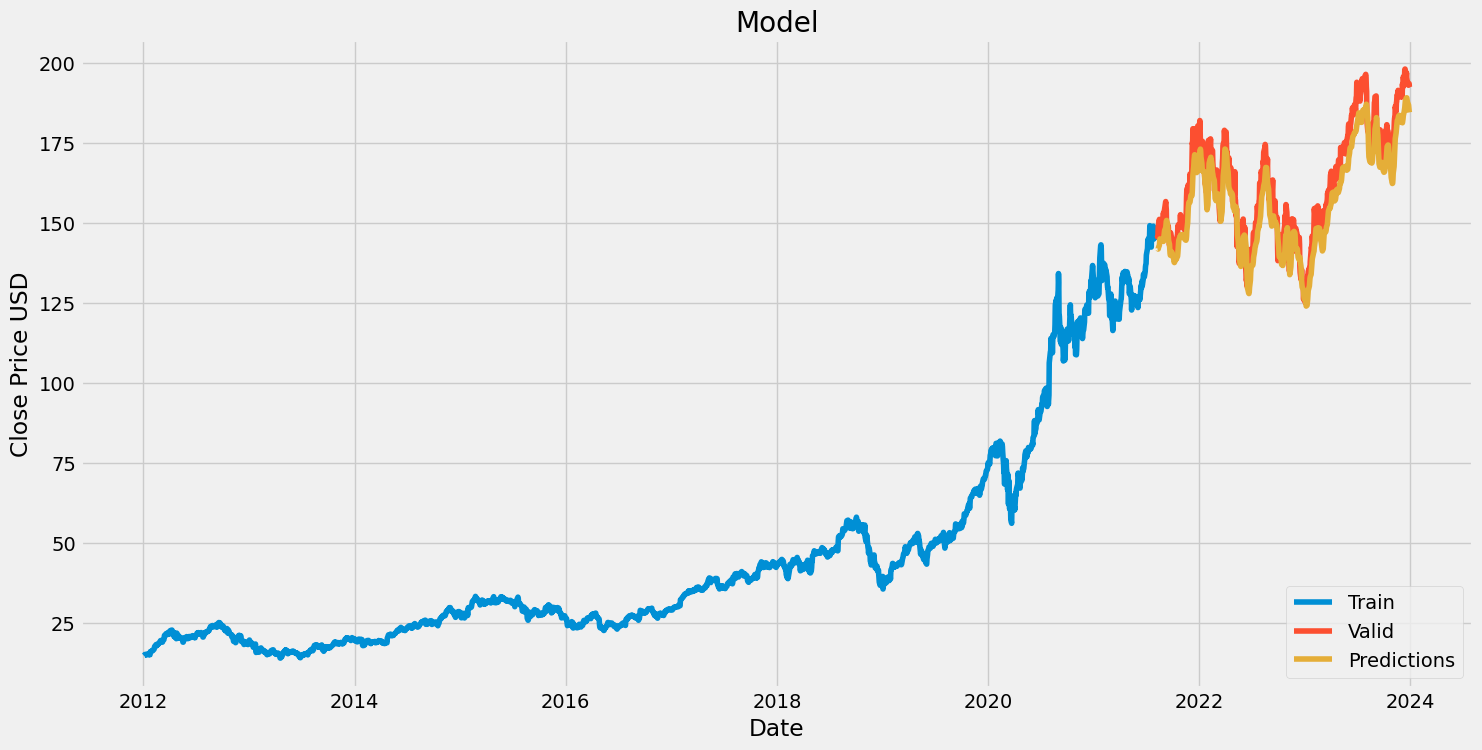

In [31]:
#plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = pred
#visualise model
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show()


In [21]:
#show actual and predicted price
valid

,Close,Predictions
Date,,
2021-08-09,146.089996,146.936096
2021-08-10,145.600006,146.946747
2021-08-11,145.860001,146.480728
2021-08-12,148.889999,146.783173
2021-08-13,149.100006,149.911880
...,...,...
2023-12-22,193.600006,193.242935
2023-12-26,193.050003,192.016022
2023-12-27,193.149994,191.619659


In [32]:
#get quote
apple_quote = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2023-10-26')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test  = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 25ms/step
[[165.9785]]


In [34]:
apple_quote2 = pdr.get_data_yahoo('AAPL', start='2023-10-27', end='2023-10-28')
print(apple_quote2['Close'])

[*********************100%%**********************]  1 of 1 completed

Date
2023-10-27    168.220001
Name: Close, dtype: float64
